### Create the data 

In [3]:
import numpy as np 
from scipy import linalg 

n_samples, n_features, rank = 500, 25, 5
sigma = 1.0

rng = np.random.RandomState(42)

U, _, _ = linalg.svd(rng.randn(n_features, n_features)) # U, Simga, V
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

X_homo = X + sigma * rng.randn(n_samples, n_features)

sigmas = sigma * rng.rand(n_features) + sigma / 2.0 
X_hetero = X + rng.randn(n_samples, n_features) * sigmas 

### Fit the models

In [4]:
import matplotlib.pyplot as plt 

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score, GridSearchCV

In [5]:
n_components = np.arange(0, n_features, 5)

In [12]:
def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()
    
    pca_scores, fa_scores = [], [] 
    for n in n_components:
        pca.n_components = n 
        fa.n_components = n 
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))
    
    return pca_scores, fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage':shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

best n_components by PCA CV = 5
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 5
best n_components by PCA CV = 20
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 18


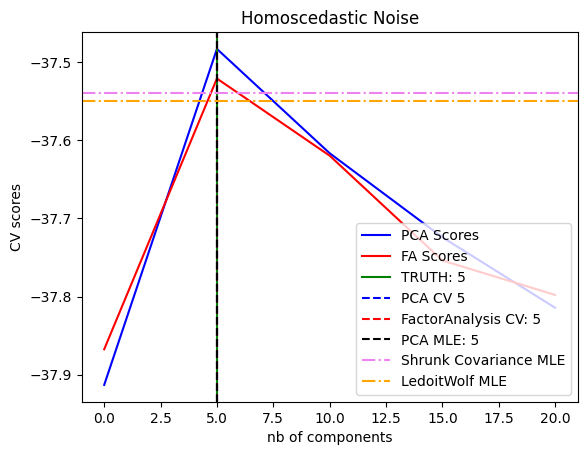

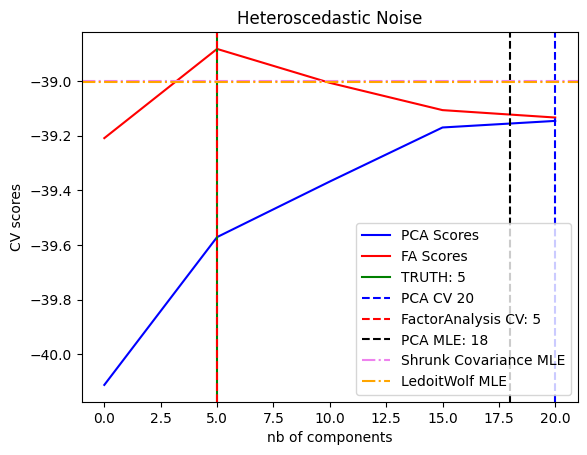

In [14]:
for X, title in [(X_homo, "Homoscedastic Noise"), (X_hetero, 'Heteroscedastic Noise')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]
    
    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    
    n_components_pca_mle = pca.n_components_
    
    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)
    
    
    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA Scores')
    plt.plot(n_components, fa_scores, 'r', label='FA Scores')
    plt.axvline(rank, color='g', label=f'TRUTH: {rank}', linestyle='-')
    plt.axvline(
        n_components_pca, 
        color='b', 
        label=f'PCA CV {n_components_pca}', 
        linestyle='--'
    )
    plt.axvline(
        n_components_fa,
        color="r",
        label="FactorAnalysis CV: %d" % n_components_fa,
        linestyle="--",
    )
    plt.axvline(
        n_components_pca_mle,
        color="k",
        label="PCA MLE: %d" % n_components_pca_mle,
        linestyle="--",
    )

    # compare with other covariance estimators
    plt.axhline(
        shrunk_cov_score(X),
        color="violet",
        label="Shrunk Covariance MLE",
        linestyle="-.",
    )
    plt.axhline(
        lw_score(X),
        color="orange",
        label="LedoitWolf MLE" % n_components_pca_mle,
        linestyle="-.",
    )

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc="lower right")
    plt.title(title)

plt.show()